In [3]:

from timeit import timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rrmpg.models import HBVEdu
from rrmpg.data import CAMELSLoader
from rrmpg.tools.monte_carlo import monte_carlo
from rrmpg.utils.metrics import calc_nse
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import pickle
from scipy.optimize import minimize



## Create a model

Initialize a model **with** specific model parameters.

The [documentation](http://rrmpg.readthedocs.io) provides a list of all model parameters. Alternatively we can look at `help()` for the model (e.g. `help(CemaneigeGR4J)`).


In [4]:
inits = {'T_t': 0.27395230965771034,
 'DD': 3.154313607022683,
 'FC': 104.42443743823611,
 'Beta': 5.304786506345334,
 'C': 0.065263466255956,
 'PWP': 159.8187599937998,
 'K_0': 0.19668052403227315,
 'K_1': 0.0721873514094736,
 'K_2': 0.041983486905955915,
 'K_p': 0.04861741901925339,
 'L': 3.6562694176139416}
model = HBVEdu()
model.set_params(inits)
model.get_params()

{'T_t': 0.27395230965771034,
 'DD': 3.154313607022683,
 'FC': 104.42443743823611,
 'Beta': 5.304786506345334,
 'C': 0.065263466255956,
 'PWP': 159.8187599937998,
 'K_0': 0.19668052403227315,
 'K_1': 0.0721873514094736,
 'K_2': 0.041983486905955915,
 'K_p': 0.04861741901925339,
 'L': 3.6562694176139416}

## Using the CAMELSLoader

In [5]:
df = CAMELSLoader().load_basin('01031500')
df.head()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),PET,QObs(mm/d)
1980-10-01,41050.80,0.00,286.90,0.0,16.19,4.31,825.78,1.5713,0.5550
1980-10-02,40780.81,2.08,195.94,0.0,13.46,5.72,920.18,1.2619,0.4979
1980-10-03,40435.21,5.57,172.60,0.0,17.84,8.61,1128.70,1.2979,0.5169
1980-10-04,40435.21,23.68,170.45,0.0,16.28,7.32,1027.91,1.2251,1.5634
1980-10-05,40089.58,3.00,113.83,0.0,10.51,5.01,881.61,0.9116,2.8541


In [6]:
help(model.fit)

Help on method fit in module rrmpg.models.hbvedu:

fit(qobs, temp, prec, month, PE_m, T_m, snow_init=0.0, soil_init=0.0, s1_init=0.0, s2_init=0.0) method of rrmpg.models.hbvedu.HBVEdu instance
    Fit the HBVEdu model to a timeseries of discharge.
    
    This functions uses scipy's global optimizer (differential evolution)
    to find a good set of parameters for the model, so that the observed 
    discharge is simulated as good as possible.
    
    Args:
        qobs: Array of observed streamflow discharge.
        temp: Array of (mean) temperature for each timestep.
        prec: Array of (summed) precipitation for each timestep.
        month: Array of integers indicating for each timestep to which
            month it belongs [1,2, ..., 12]. Used for adjusted
            potential evapotranspiration.
        PE_m: long-term mean monthly potential evapotranspiration.
        T_m: long-term mean monthly temperature.
        snow_init: (optional) Initial state of the snow reservoi

In [7]:

qobs = df["QObs(mm/d)"]
temp = (df["tmax(C)"]+ df["tmin(C)"])/2
df["mean_temp"] = (df["tmax(C)"]+ df["tmin(C)"])/2
prec = df["prcp(mm/day)"]
month = df.index.month
df["month_index"] = df.index.month

df['year']=df.index.year
df["month"]=df.index.month


monthly_pet = df.groupby(['year','month'])['PET'].mean().reset_index()
long_term_pet = monthly_pet.groupby('month')['PET'].mean().reset_index()

monthly_temp = df.groupby(['year','month'])['mean_temp'].mean().reset_index()
long_term_temp = monthly_temp.groupby('month')['mean_temp'].mean().reset_index()

long_term_temp



,month,mean_temp
0,1,-10.861082
1,2,-9.030222
2,3,-3.853714
3,4,3.553912
4,5,10.386352
5,6,15.647392
6,7,18.539288
7,8,17.596973
8,9,13.042118
9,10,6.522894


In [8]:
# calcute the end date of the calibration period
end_cal = pd.to_datetime(f"{df.index[0].year + 15}/09/30", yearfirst=True)

# validation period starts one day later
start_val = end_cal + pd.DateOffset(days=1)

# split the data into two parts
cal = df[:end_cal].copy()
val = df[start_val:].copy()

## Fit the model to observed discharge


In [9]:
help(model.fit)

Help on method fit in module rrmpg.models.hbvedu:

fit(qobs, temp, prec, month, PE_m, T_m, snow_init=0.0, soil_init=0.0, s1_init=0.0, s2_init=0.0) method of rrmpg.models.hbvedu.HBVEdu instance
    Fit the HBVEdu model to a timeseries of discharge.
    
    This functions uses scipy's global optimizer (differential evolution)
    to find a good set of parameters for the model, so that the observed 
    discharge is simulated as good as possible.
    
    Args:
        qobs: Array of observed streamflow discharge.
        temp: Array of (mean) temperature for each timestep.
        prec: Array of (summed) precipitation for each timestep.
        month: Array of integers indicating for each timestep to which
            month it belongs [1,2, ..., 12]. Used for adjusted
            potential evapotranspiration.
        PE_m: long-term mean monthly potential evapotranspiration.
        T_m: long-term mean monthly temperature.
        snow_init: (optional) Initial state of the snow reservoi

In [10]:
# calculate mean temp for calibration and validation period
cal['tmean'] = (cal['tmin(C)'] + cal['tmax(C)']) / 2
val['tmean'] = (val['tmin(C)'] + val['tmax(C)']) / 2

# load the gauge station height
height = CAMELSLoader().get_station_height('01031500')

In [11]:
# save the initial model for future references. To recreate same results
result = model.fit(cal['QObs(mm/d)'], cal['tmean'], cal['prcp(mm/day)'], 
                   cal['month_index'], long_term_pet['PET'], long_term_temp['mean_temp'])

with open('model/optimization_result.pkl', 'wb') as f:
    pickle.dump(result, f)

In [15]:

with open('model/optimization_result.pkl', 'rb') as f:
    loaded_result = pickle.load(f)

loaded_result

     fun: 4.0093799696884975
 message: 'Optimization terminated successfully.'
    nfev: 3921
     nit: 16
 success: True
       x: array([-1.71571421e-01,  3.14658385e+00,  1.73743614e+02,  2.24712331e+00,
        6.19773134e-02,  1.57959698e+02,  1.69491309e-01,  9.92397910e-02,
        4.11740544e-02,  4.97597828e-02,  4.81500436e+00])

`result` is an object defined by the scipy library and contains the optimized model parameters, as well as some more information on the optimization process. Let us have a look at this object:

In [16]:
result

     fun: 4.016997792816812
 message: 'Optimization terminated successfully.'
    nfev: 4860
     nit: 23
 success: True
       x: array([-1.82361512e-01,  3.19846041e+00,  1.75357614e+02,  2.12219129e+00,
        1.72964104e-02,  1.62500283e+02,  1.91364523e-01,  9.93445945e-02,
        4.65207913e-02,  4.70620534e-02,  4.98413908e+00])


- `fun` is the final value of our optimization criterion (the mean-squared-error in this case)
- `message` describes the cause of the optimization termination
- `nfev` is the number of model simulations
- `sucess` is a flag wether or not the optimization was successful
- `x` are the optimized model parameters


In [17]:
params = {}

param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = loaded_result.x[i]

model.set_params(params)

model.get_params()

{'T_t': -0.1715714214386017,
 'DD': 3.1465838464605698,
 'FC': 173.74361393207556,
 'Beta': 2.247123308555528,
 'C': 0.06197731339524527,
 'PWP': 157.95969827223382,
 'K_0': 0.16949130903282178,
 'K_1': 0.09923979096992544,
 'K_2': 0.04117405437760092,
 'K_p': 0.04975978275618893,
 'L': 4.815004355815933}

## Calculate simulated discharge


In [18]:

val['qsim_fit'] = model.simulate( val['tmean'], val['prcp(mm/day)'], 
                   val['month_index'], long_term_pet['PET'], long_term_temp['mean_temp'])

# Calculate and print the Nash-Sutcliff-Efficiency for both simulations
nse_fit = calc_nse(val['QObs(mm/d)'], val['qsim_fit'])

print("NSE of the .fit() optimization: {:.4f}".format(nse_fit))

NSE of the .fit() optimization: 0.6542


<IPython.core.display.Javascript object>


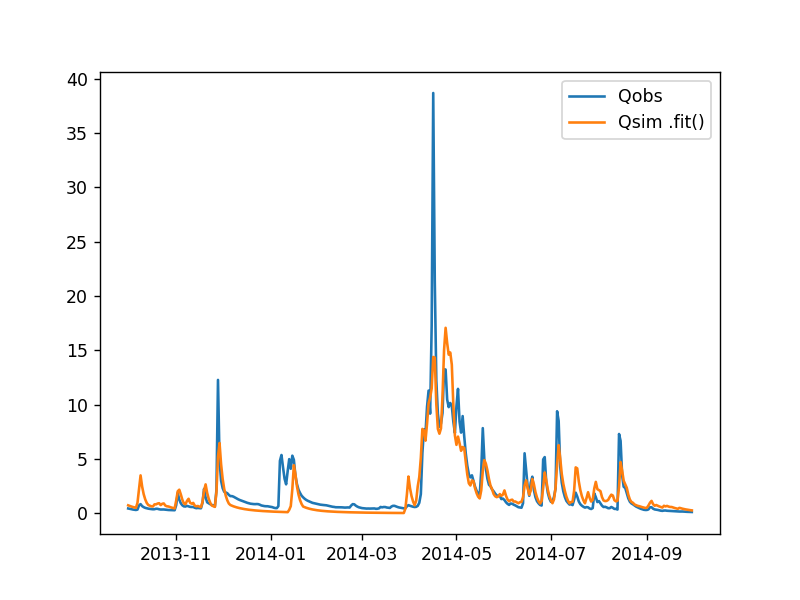

In [19]:

%matplotlib notebook
start_date = pd.to_datetime("2013/10/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Qobs')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Qsim .fit()')
plt.legend()